# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [1]:
# import libraries here; add more as necessary
from collections import defaultdict
import re

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#import seaborn as sns

from sklearn.preprocessing import Imputer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# magic word for producing visualizations in notebook
%matplotlib inline

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [2]:
# Load in the general demographics data.
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv', delimiter=';')

# Load in the feature summary file.
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', delimiter=';')

In [3]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).
display(azdias.head(n=10))

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0
5,3,1,2,2.0,3,1,5,2,2,5,...,2.0,3.0,1.0,1.0,1.0,5.0,5.0,2.0,3.0,3.0
6,-1,2,2,5.0,1,5,1,5,4,3,...,3.0,3.0,1.0,0.0,1.0,5.0,5.0,4.0,6.0,3.0
7,-1,1,1,3.0,3,3,4,1,3,2,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,2.0,5.0,2.0
8,-1,3,1,3.0,4,4,2,4,2,2,...,2.0,3.0,2.0,1.0,1.0,3.0,3.0,2.0,4.0,3.0
9,-1,3,2,4.0,2,4,2,3,5,4,...,2.0,3.0,2.0,1.0,1.0,3.0,3.0,2.0,3.0,1.0


In [4]:
display(feat_info.head(n=5))

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]


> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [5]:
def make_columns_metadata():
    """ Make columns metadata.
    
        Return dictionary that provides access to column
        metadata by column name.
        
        Column metadata:
        - column type
        - predicate function objects, encodes missing value criterion.
    """
    # Define regular expression to select
    # collection of codes for missing values. 
    re_missing = re.compile('^\[(.*?)\]$')
    
    def make_is_missing(missing_or_unknown):
        """ Return function object that identifies
            missing values.

            Parameters
            ----------
            missing: missing_or_unknown values.
        """
        codes = re_missing.search(missing_or_unknown).groups()[0].split(',')
        def is_missing(x):
            value = str(x).split('.')[0]
            return value in codes
        return is_missing

    meta = {
        "columns": [col for col in feat_info]
    }
    
    for _, row in feat_info.iterrows():
        meta[row['attribute']] = {
            'type': row['type'],
            'is_missing': make_is_missing(row['missing_or_unknown'])
        }
    return meta

In [6]:
# Capture empty values frequency in a dataset.
def empty_values_by_column(df):
    """ Return collection of pairs (column-name, ratio),
        where `ratio` is a ratio of empty values per column.
        
        Parameters:
        df ::= pandas data frame.
    """
    N = df.shape[0]
    return [(name, count / N) for name, count in df.isnull().sum().iteritems()]


# Identify missing or unknown data values and convert them to NaNs.
def transform_missing_to_nan(df, metadata):
    """ Return data frame with missing or unknown
        data set to NaN.
        
        Parameters:
        df ::= pandas data frame
        metadata ::= dictionary, columns metadata.
    """
    df_p = df.copy()
    for col in df:
        predicate = metadata[col]['is_missing']
        df_p[col] = df[col].apply(lambda x: np.nan if predicate(x) else x)
    return df_p

In [7]:
# Capture empty values frequency in a dataset.
empty_values_stats = empty_values_by_column(azdias)
# Identify missing or unknown data values and convert them to NaNs.
df_p = transform_missing_to_nan(azdias, make_columns_metadata())
df_p.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,NaN,2.0,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,1.0,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,NaN,3.0,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2.0,4.0,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,NaN,3.0,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

name: TITEL_KZ        nan-ratio=0.998  empty-ratio=0.082
name: AGER_TYP        nan-ratio=0.770  empty-ratio=0.000
name: KK_KUNDENTYP    nan-ratio=0.656  empty-ratio=0.656
name: KBA05_BAUMAX    nan-ratio=0.535  empty-ratio=0.150
name: GEBURTSJAHR     nan-ratio=0.440  empty-ratio=0.000
name: ALTER_HH        nan-ratio=0.348  empty-ratio=0.082
name: KKK             nan-ratio=0.177  empty-ratio=0.136
name: REGIOTYP        nan-ratio=0.177  empty-ratio=0.136
name: W_KEIT_KIND_HH  nan-ratio=0.166  empty-ratio=0.121
name: KBA05_ANTG1     nan-ratio=0.150  empty-ratio=0.150
name: KBA05_ANTG2     nan-ratio=0.150  empty-ratio=0.150
name: KBA05_ANTG3     nan-ratio=0.150  empty-ratio=0.150
name: KBA05_ANTG4     nan-ratio=0.150  empty-ratio=0.150
name: KBA05_GBZ       nan-ratio=0.150  empty-ratio=0.150
name: MOBI_REGIO      nan-ratio=0.150  empty-ratio=0.150
name: PLZ8_ANTG1      nan-ratio=0.131  empty-ratio=0.131
name: PLZ8_ANTG2      nan-ratio=0.131  empty-ratio=0.131
name: PLZ8_ANTG3      nan-ratio

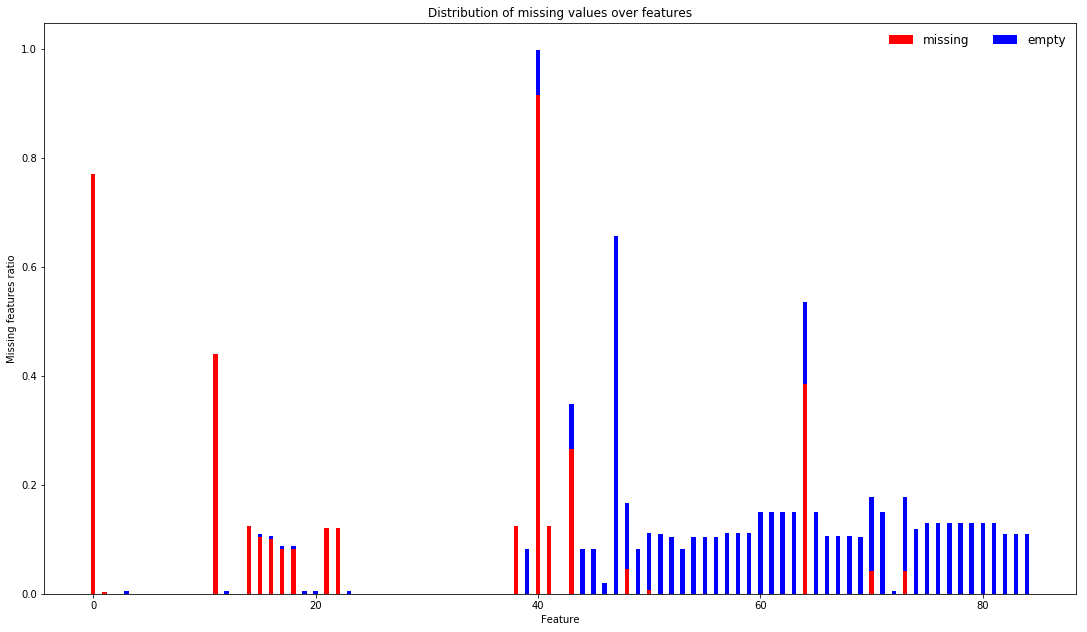

In [8]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.

def plot_missing_values_distribution(df, empty_values_stats):
    """
        Parameters
        ----------
        df ::= pandas data frame
        empty_values_stats ::= collection of pairs (column, ratio) representing ratio of
                               empty values per column in original data set.
    """
    N, _ = df.shape
    nan_values_stats = [(name, count/N) for name, count in df.isnull().sum().iteritems()]
    counts = sorted([(name, ratio, idx) for idx, (name, ratio) in enumerate(nan_values_stats) if ratio > 0], 
                       key=lambda x: x[1], 
                       reverse=True)

    for name, ratio, index in counts:
        print("name: {:15} nan-ratio={:.03f}  empty-ratio={:0.3f}".format(name, 
                                                                          ratio, 
                                                                          empty_values_stats[index][1]))

    nans = np.array([ratio for _, ratio in nan_values_stats])
    empty = np.array([ratio for _, ratio in empty_values_stats])
    nans -= empty
    index = np.arange(len(nans))

    fig = plt.gcf()
    fig.set_size_inches(18.5, 10.5)
    width = 0.4
    p1 = plt.bar(index, nans, width, color='r')
    p2 = plt.bar(index, empty, width, bottom=nans, color='b')
    plt.ylabel("Missing features ratio")
    plt.xlabel("Feature")
    plt.title("Distribution of missing values over features")
    plt.legend((p1[0], p2[0]), ('missing', 'empty'), fontsize=12, ncol=2, framealpha=0, fancybox=True)
    plt.show()
    
# Plot distribution of missing and empty values.
plot_missing_values_distribution(df_p, empty_values_by_column(azdias))

In [9]:
# Investigate patterns in the amount of missing data in each column.
def missing_values_counts_by_column(df):
    """ Return collection of pairs (name, count), where
        - name: column name
        - count: number of missing values per column
    """
    return [(name, count) for name, count in df.isnull().sum().iteritems() if count > 0]

def group_columns_by_amount_of_missing_data(df):
    """
        Parameters
        ----------
        df ::= pandas data frame
    """
    N, _ = df.shape
    group_by_count = defaultdict(list)
    
    for name, count in missing_values_counts_by_column(df):
        group_by_count[count].append(name)
    
    groups = [(count/N, cols) for count, cols in group_by_count.items() if len(cols) > 1]
    for i, (ratio, cols) in enumerate(sorted(groups, key=lambda x: len(x[1]), reverse=True)):
        print("{:2}. Missing values ratio: {:0.3f}".format(i+1, ratio))
        print("\t{}\n".format(", ".join(cols)))

group_columns_by_amount_of_missing_data(df_p)

 1. Missing values ratio: 0.131
	PLZ8_ANTG1, PLZ8_ANTG2, PLZ8_ANTG3, PLZ8_ANTG4, PLZ8_BAUMAX, PLZ8_HHZ, PLZ8_GBZ

 2. Missing values ratio: 0.005
	CJT_GESAMTTYP, GFK_URLAUBERTYP, LP_STATUS_FEIN, LP_STATUS_GROB, RETOURTYP_BK_S, ONLINE_AFFINITAET

 3. Missing values ratio: 0.150
	KBA05_ANTG1, KBA05_ANTG2, KBA05_ANTG3, KBA05_ANTG4, KBA05_GBZ, MOBI_REGIO

 4. Missing values ratio: 0.082
	SOHO_KZ, ANZ_PERSONEN, ANZ_TITEL, WOHNDAUER_2008

 5. Missing values ratio: 0.105
	GEBAEUDETYP, MIN_GEBAEUDEJAHR, OST_WEST_KZ, WOHNLAGE

 6. Missing values ratio: 0.125
	HEALTH_TYP, SHOPPER_TYP, VERS_TYP

 7. Missing values ratio: 0.111
	CAMEO_DEUG_2015, CAMEO_DEU_2015, CAMEO_INTL_2015

 8. Missing values ratio: 0.105
	BALLRAUM, EWDICHTE, INNENSTADT

 9. Missing values ratio: 0.087
	LP_FAMILIE_FEIN, LP_FAMILIE_GROB

10. Missing values ratio: 0.177
	KKK, REGIOTYP

11. Missing values ratio: 0.109
	ARBEIT, RELAT_AB



In [10]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)

def outlier_column_names(df, threshold):
    """ Return collection of columns names such that
        ratio of missing values per column is greater than
        specified threshold.
        
        Parameters
        ----------
        df        ::= pandas data frame
        threshold ::= missing values outlier threshold 
    """
    N, _ = df.shape
    return [name for name, count in missing_values_counts_by_column(df) if count/N > threshold]

def drop_columns(df, columns):
    """ Return copy of the data frame
        without specified columns.
        
        Parameters
        ----------
        df       ::= pandas data frame
        columns ::= collection of columns to drop from the  data frame.
    """
    df_p = df.drop(columns, axis=1)
    return df_p

outlier_names = outlier_column_names(df_p, 0.5) 
columns_to_drop = outlier_names[:]
for col in df_p.columns:
    if col.endswith('_FEIN'):
        columns_to_drop.append(col)
#columns_to_drop.append('CAMEO_DEU_2015')
        
df_no_outliers = drop_columns(df_p,  columns_to_drop)

print("Dropped columns: {}".format(", ".join(columns_to_drop)))
print("Data set rows: {} columns: {}".format(df_no_outliers.shape[0], df_no_outliers.shape[1]))

Dropped columns: AGER_TYP, TITEL_KZ, KK_KUNDENTYP, KBA05_BAUMAX, LP_LEBENSPHASE_FEIN, LP_FAMILIE_FEIN, LP_STATUS_FEIN
Data set rows: 891221 columns: 78


# Discussion 1.1.2: Assess Missing Data in Each Column

(Double click this cell and replace this text with your own text, reporting your observations regarding the amount of missing data in each column. Are there any patterns in missing values? Which columns were removed from the dataset?)

All columns with missing values, except ''TITEL_KZ', 'AGER_TYP', 'KK_KUNDENTYP', 'GEBURTSJAHR' columns, form groups such that number of missing values is identical for all columns in a group.

There are 11 groups of columns that share same ratio of missing values.

It is possible that variables / columns /, which belong to these 11 groups, are missing values not at random. Theses variables do not have values either because of variables' values itself, or because of values of other variables.

Groups of columns

    Ratio: 0.177, Columns: 2
    Ratio: 0.150, Columns: 6
    Ratio: 0.131, Columns: 7
    Ratio: 0.125, Columns: 3
    Ratio: 0.111, Columns: 3
    Ratio: 0.109, Columns: 2
    Ratio: 0.105, Columns: 3
    Ratio: 0.087, Columns: 2
    Ratio: 0.082, Columns: 4
    Ratio: 0.005, Columns: 6

Variables 'TITEL_KZ', 'AGER_TYP', 'KK_KUNDENTYP' could be considered as outliers, based on ratio of missing values: 0.998, 0.770, 0.656.

Outliers were dropped from the data set.

I also dropped columns with names ending in `_FEIN`: each such column represents a fine scale and there is a corresponding column that represents a rough scale. Such variables are correlated with coefficient 1, and we need independent variables.<br> Ideally I would have opted to drop a variable that represents rough scale and split fine scale variable into two, but there is not enough information to do so.  I decided to keep features that represent rough scale and drop features that represent fine scale.

#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. Make sure you report your observations in the discussion section. **Either way, you should continue your analysis below using just the subset of the data with few or no missing values.**

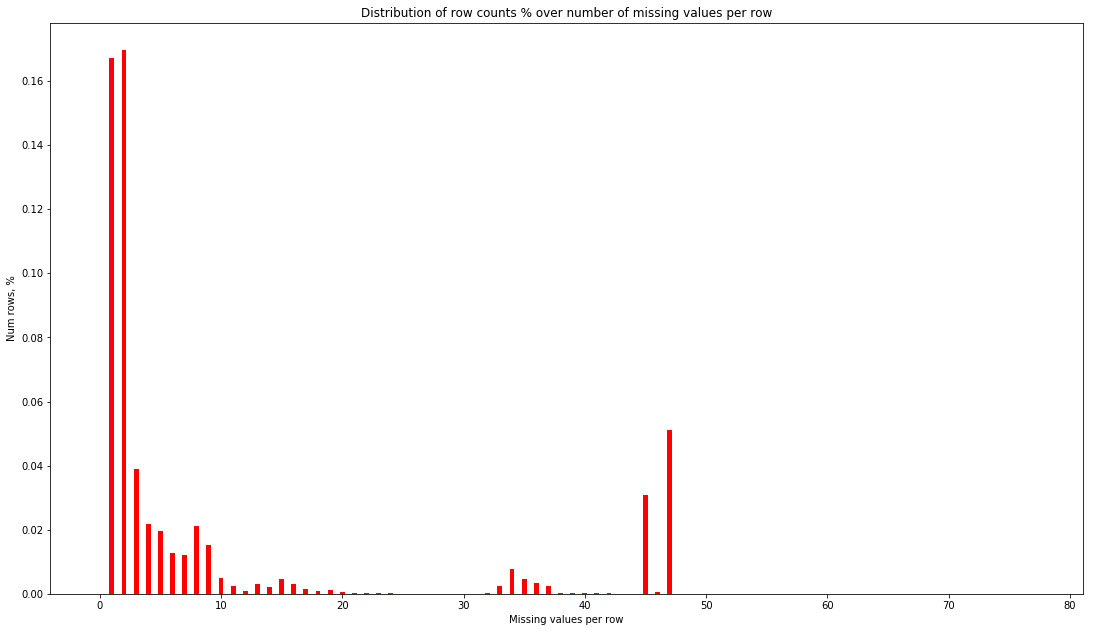

In [11]:
# How much data is missing in each row of the dataset?
def plot_distribution_of_rows_over_missing_value_counts_per_row(df):
    """ Return collection of pairs (index, count) where
         - index: row index
         - count: number of features with missing values
    """
    items = [(index, count) for index, count in df.isnull().sum(axis=1).iteritems() if count > 0]
    statistic = defaultdict(int)
    for _, count in items:
        statistic[count] += 1
    
    N, C = df.shape
    index = np.arange(C)
    x = [statistic[i] / N for i in index]
    
    fig = plt.gcf()
    fig.set_size_inches(18.5, 10.5)
    ax = fig.add_subplot(111)
    width = 0.4
    p = ax.bar(index, x, width, color='r')
    ax.set_ylabel('Num rows, %')
    ax.set_xlabel('Missing values per row')
    ax.set_title("Distribution of row counts % over number of missing values per row")
    plt.show()
    
# Plot row count % over how much data is missing in each row of the dataset
plot_distribution_of_rows_over_missing_value_counts_per_row(df_no_outliers)

In [12]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.
def split_dataset_by_missing_values(df, threshold):
    """ Return pair (df_good, df_other) where
        - df_good: contains rows s. t. missing values count per row is less than the threshold.
        - df_other: contains rows s. t. missing values count per row is greater than the threshold.
        
        Parameters
        -----------
        df: data frame
        threshold: missing values per row ratio threshold. 
    """
    _, num_feat = df.shape
    # Define criterion to split data set into two subsets
    criterion = (df.isnull().sum(axis=1)/num_feat <= threshold)   
    return df[criterion], df[criterion == False]

In [13]:
df_good, df_other = split_dataset_by_missing_values(df_no_outliers, 0.5)

In [14]:
df_good.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
1,1.0,2,5.0,1,5,2,5,4,5,1,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,3.0,2,3.0,1,4,1,2,3,5,1,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,4.0,2,2.0,4,2,5,2,1,2,6,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,3.0,1,5.0,4,3,4,1,3,2,5,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0
5,1.0,2,2.0,3,1,5,2,2,5,2,...,2.0,3.0,1.0,1.0,1.0,5.0,5.0,2.0,3.0,3.0


In [15]:
df_other.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,2.0,1,2.0,3,4,3,5,5,3,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11,2.0,1,6.0,3,4,3,5,5,3,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
14,3.0,1,6.0,3,4,3,5,5,3,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
17,2.0,1,6.0,3,4,3,5,5,3,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
24,3.0,2,6.0,3,4,3,5,5,3,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [16]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.

# Select five columns with no or few missing values
def select_columns_by_missing_value_count(df, predicate, n=5):
    """ Return specified number of columns names
        selected at random.
        Collection of columns to choose from contains columns 
        that match specified missing values count criterion. 
    """
    return np.random.choice([name for name, count in df.isnull().sum().iteritems() if predicate(count)], 
                            size=n,
                            replace=False)


In [17]:
def plot_distribution_of_values(df_lhs, df_rhs, columns):
    """
        Plot distribution of values for a column for two data frames.
        Parameters
        ----------
        df_lhs  ::= data frame / good
        df_rhs  ::= data frame / other
        colunms ::= collection of columns to plot distribution of values for.  
    """
    num_plots = len(columns)
    cells_x= 3
    cells_y = num_plots // cells_x + 1
    
    counts = {}
    fig = plt.figure()
    fig.set_size_inches(18, 10)
    plots = []
    width = 0.4

    errors = []
    for index, col in enumerate(columns):
        lhs, rhs = df_lhs[col].value_counts(sort=False, normalize=True), df_rhs[col].value_counts(sort=False, normalize=True)
        x, u, v = [], [], []
        i, j = 0, 0
        while i < len(lhs) and j < len(rhs):
            k1 = int(lhs.keys()[i])
            k2 = int(rhs.keys()[j])
            if k1 == k2:
                x.append(k1)
                u.append(lhs.values[i])
                v.append(rhs.values[j])
                i += 1
                j += 1
            elif k1 < k2:
                x.append(k1)
                u.append(lhs.values[i])
                v.append(0)
                i += 1
            else:
                x.append(k2)
                u.append(0)
                v.append(rhs.values[j])
                j += 1

        while i < len(lhs):
            k1 = int(lhs.keys()[i])
            x.append(k1)
            u.append(lhs.values[i])
            v.append(0)
            i += 1

        while j < len(rhs):
            k2 = int(rhs.keys()[j])
            x.append(k2)
            u.append(0)
            v.append(rhs.values[j])
            j += 1

        # Mean squared value distribution error
        mse = np.mean((np.array(u) - np.array(v))**2)
        errors.append((col, mse))
        
        ax = fig.add_subplot(cells_y, cells_x, index+1)
        plots.append(ax)
        x = np.array(x)
        b1 = ax.bar(x, u, width, color='b')
        b2 = ax.bar(x, v, width, bottom=u, color='r')
        ax.autoscale(tight=True)
        ax.set_ylabel('Freq')
        ax.set_xlabel('Values')
        ax.set_title(col)
        plt.legend((b1[0], b2[0]), ('good', 'other'))
    plt.show()    
    
    print("Value distribution mean squared error:\n")
    for name, e in errors:
        print("Name: {}, error: {:.03f}".format(name, e))
    

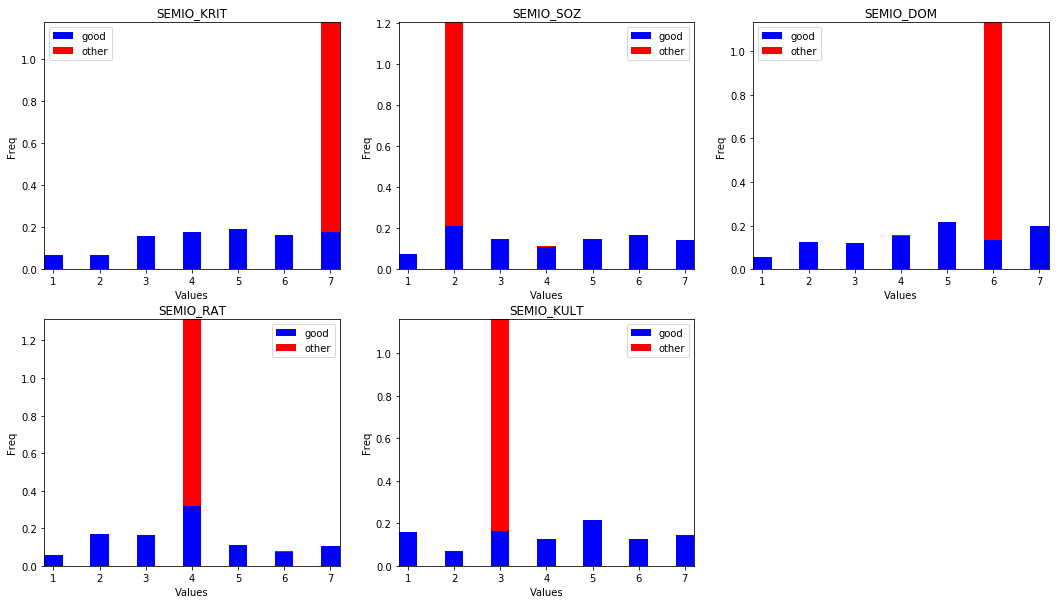

Value distribution mean squared error:

Name: SEMIO_KRIT, error: 0.114
Name: SEMIO_SOZ, error: 0.104
Name: SEMIO_DOM, error: 0.127
Name: SEMIO_RAT, error: 0.078
Name: SEMIO_KULT, error: 0.117


In [18]:
cols = select_columns_by_missing_value_count(df_no_outliers, predicate=lambda count: count <= 3)
plot_distribution_of_values(df_good, df_other, cols)

#### Discussion 1.1.3: Assess Missing Data in Each Row

The data set can be divided into two groups, based on number of missing values per row statistic.
Threshold set to 50% of missing values per row splits the data set into two groups of rows. These two groups exhibit distinct  distribution of values for columns with no or very few missing values, as seen on subplots in the above cell.
Rows of the data set with at least 50% of missing values per row have no variance in column values for most of the columns.
Therefore the data with many missing values looks very different from the data with few or no missing values, and dropping these samples from analysis will affect quality of the analysis.

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [19]:
# How many features are there of each data type?
feat_info.groupby(['type']).count()


,attribute,information_level,missing_or_unknown
type,,,
categorical,21,21,21
interval,1,1,1
mixed,7,7,7
numeric,7,7,7
ordinal,49,49,49


#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [20]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?

def make_categorical_data_transforms(df, engineered_feat=[]):
    """ Return collection of tuples (category-type, column-name, caridnality, transform-function)
        for categorical columns.
        
        Parameters
        ----------
        df ::= pandas data frame.
    """
    def make_binary_transform(column_name, values):
        """ Return function object that trasforms
            value of specified column according to a mapping.
            
            Parameters
            ----------
            column_name  ::= binary column name
            values      ::= collection of values to map.
        """
        if len(values) != 2:
            raise ValueError('values collection must have two entries')
        mapping = {v: i for i, v in enumerate(values)}
        
        def transform(df):
            transformed = pd.Series(df[column_name], copy=True)
            for key, value in mapping.items():
                transformed.replace(key, value, inplace=True)
            df[column_name] = transformed
            return df
        
        return transform

    def make_onehot_transform(column_name):
        """ Return function object that makes on hot encoding
            for specified column and drops original column from 
            the data set.
            
            Parameters
            ----------
            column_name ::= name of column to produce one hot encoding for.
        """
        def transform(df):
            df = pd.concat([df, pd.get_dummies(df[column_name], prefix=column_name, dummy_na=False)], axis=1)
            df.drop([column_name], axis=1, inplace=True)
            return df
        return transform
    
    transforms = []
    columns = set([col for col in df])
    cols = [s['attribute'] for _, s in feat_info.loc[feat_info['type'] == 'categorical'].iterrows()]
    # Add names of engineered features
    cols.extend(engineered_feat)
    
    for col_name in [c for c in cols if c in columns]:
        counts = df[col_name].value_counts(sort=False)
        if len(counts) == 2:
            try:
                int(counts.keys()[0])
            except ValueError:
                transforms.append(('binary', col_name, 2, make_binary_transform(col_name, counts.keys())))    
            else:
                pass
        else:
            transforms.append(('multilevel', col_name, len(counts), make_onehot_transform(col_name)))
    return transforms

In [21]:
def encode_nominal_to_numeric(df, engineered_feat=[]):
    """ Return copy of specified data frame where non-numeric 
        values of categorical features were transformed to numeric values.
    """
    def to_numeric(series):
        """Convert character code to numeric code.
        """
        counts = series.value_counts()
        mapping = {k: i+1 for i, k in enumerate(counts.keys())}
        series_p = pd.Series(series, copy=True)
        for key, value in mapping.items():
            series_p.replace(key, value, inplace=True) 
        return series_p
    
    regex = re.compile('[A-Za-z]')
    def has_alpha(values):
        """ Return True is value has alphabetical char.
            Which is an indicator of nominal value.
        """
        for value in values:
            match = regex.search(str(value))
            if match is not None:
                return True
        return False
    
    df_p = df.copy()
    columns = set([col for col in df])
    
    cols = [s['attribute'] for _, s in feat_info.loc[feat_info['type'] == 'categorical'].iterrows()]
    # Add names of engineered features
    cols.extend(engineered_feat)
    for col_name in [c for c in cols if c in columns]:
        if has_alpha(df[col_name].value_counts().keys()):
            df_p[col_name] = to_numeric(df_p[col_name])
    return df_p    

In [22]:
# Re-encode categorical variable(s) to be kept in the analysis.
def encode_categorical_values(df, engineered_feat=[], verbose=False):
    """ Return data set with re-encoded categorical values.
    """
    df_p = df.copy()
    transforms = make_categorical_data_transforms(df_p, engineered_feat)
    for tag, column, card, transform in transforms:
        df_p = transform(df_p)
        if verbose:
            print("Transformed category={} cardinality={} name={}".format(tag, card, column))
    return df_p
    
df_encoded = encode_categorical_values(df_good)
print("\nData frame shape after encoding categoricals: {}".format(df_encoded.shape))


Data frame shape after encoding categoricals: (817078, 174)


#### Investigate column CAMEO_DEU_2015, which has 44 distinct values.

Cardinality of `CAMEO_DEU_2015` column is high: 44 distinct values. This columns might have been incorrectly classified as `categorical multilevel` and belongs to `mixed` category.
There is a column with similar name - `CAMEO_DEUG_2015`. Let's review values of these columns by printing their values side-by-side:
- 8A, 8
- 4C, 4
- 2A, 2
- 6B, 6
- 8C, 8
- 4A, 4
- 2D, 2
- 1A, 1
- 1E, 1
- 9D, 9
- ...

It looks like value of the `CAMEO_DEUG_2015` is a prefix of value of the 'CAMEO_DEU_2015' column. We will write a function that iterates over all rows of the data set and computes how many times value of `CAMEO_DEUG_2015` matches prefix of the `CAMEO_DEU_2015`.

If match is 100% then `CAMEO_DEU_2015` is a column of `mixed` type, and its values can be split into two categories.
We will keep `CAMEO_DEUG_2015` column as is, and we will transform values of `CAMEO_DEU_2015` column by removing integer prefix from the column's values.


In [23]:
# Investigate values of CAMEO_DEU_2015 column: cardinality 44
#print(df_good['CAMEO_DEU_2015'].value_counts(sort=True))

def make_match_count(df):
    """ Return pair of (match, mismatch) counts that reflects
        how many times value of 'CAMEO_DEUG_2015' 
        is a prefix of the 'CAMEO_DEU_2015'.
    """
    match = 0
    mismatch = 0
    regex = re.compile('^(\d+)')
    
    for index, row in df_good.iterrows():
        u = str(row['CAMEO_DEU_2015'])
        v = str(row['CAMEO_DEUG_2015'])
        try:
            if 'nan' == u and 'nan' == v:
                continue
            elif 'nan' == u or 'nan' == v:
                mismatch += 1
            else:
                try:
                    m = regex.search(u)
                except TypeError:
                    print("{} {}".format(u, type(u)))
                    raise
                if m is not None:
                    prefix = int(m.groups()[0])
                    if prefix == int(v):
                        match += 1
                    else:
                        mismatch += 1
                else:
                    mismatch += 1
        except:
            print("{} {} {} {}".format(row['CAMEO_DEU_2015'], type(row['CAMEO_DEU_2015']), row['CAMEO_DEUG_2015'], type(row['CAMEO_DEUG_2015'])))
            raise
    return match, mismatch

match, mismatch  = make_match_count(df_good)
print("Match #: {} vs. Mismatch count {}".format(match, mismatch))
print("Column CAMEO_DEU_2015 {} to mixed category.".format("belongs" if not mismatch else "does not belong"))
    

Match #: 791869 vs. Mismatch count 0
Column CAMEO_DEU_2015 belongs to mixed category.


In [24]:
# Define function to transform values of the `CAMEO_DEU_2015`
 # column.
def encode_wealth_lifestyle_topology(df):
    """ Return copy of the data frame with 
        values of `CAMEO_DEU_2015` transformed
        to contain second character of the original value.
    """
    def transform(value):
        value = str(value)
        if value == 'nan':
            return np.nan
        else:
            return value[1]
        
    name = 'CAMEO_DEU_2015'
    df_p = df.copy()
    df_p[name] = df_p[name].apply (transform)
    df_p = df.drop([name], axis=1)
    return df_p

In [25]:
def encode_features_with_low_freq_values(df):
    """
    """
    # GEBAEUDETYP: merge values 4, 5, 6 into 4
    def transform_GEBAEUDETYP(x):
        return 4 if x == 5 or x == 6 else x
    
    df_p = df.copy()
    df_p['GEBAEUDETYP'] = df_p['GEBAEUDETYP'].apply( transform_GEBAEUDETYP)
    
    return df_p

#### Discussion 1.2.1: Re-Encode Categorical Features

Re-encoding of categorical features consisted of 
- Encoding values of the `OST_WEST_KZ` column - column with binary non-numeric values.
- Transforming multi-level categorial columns to one-hot encoded columns.

Decision was to keep all the columns. While some of the columns have low variance / low entropy of its values, we will let PCA to identify axes with low variance of values.

Number of the dataset's features increased from 82 to 218 after application of re-encoding process.

One multilevel column - `CAMEO_DEU_2015` - has large number of levels: 44. Analysis of values of `CAMEO_DEU_2015` and `CAMEO_DEUG_2015` columns indicates that column `CAMEO_DEU_2015` encodes two axis, and the first axis is encoded by column `CAMEO_DEUG_2015`.

Therefore, before application of one hot encoding to the values of `CAMEO_DEU_2015` column, we shall transform its values by removing integer prefix.

Information in the `Data_Dictionary.md` file confirms that `CAMEO_DEU_2015` column encodes values of the `CAMEO_DEUG_2015` column: 
- `CAMEO_DEUG_2015`: German CAMEO: Wealth / Life Stage Typology, rough scale.
- `CAMEO_DEU_2015`: German CAMEO: Wealth / Life Stage Typology, detailed scale.

I think it could pay off - making data set less sparse - if instead of using raw values of the `CAMEO_DEU_2015` column we derive categories encoded in the column values' second character. For example, from the column's description in the `Data_Dictionary.md` file, we could infer that code 'D' describes lifestyle of a more senior, more mature person in each category.

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [26]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.
def encode_person_youth_movement(df):
    """ Return copy of specified data frame with two new columns - "youth" and "movement" - and
        without "PRAEGENDE_JUGENDJAHRE" column.
    """
    translate_table = {
        1:  (40, 'M'),
        2:  (40, 'A'),
        3:  (50, 'M'),
        4:  (50, 'A'),
        5:  (60, 'M'),
        6:  (60, 'A'),
        7:  (60, 'A'),
        8:  (70, 'M'),
        9:  (70, 'A'),
        10: (80, 'M'),
        11: (80, 'A'),
        12: (80, 'M'),
        13: (80, 'A'),
        14: (90, 'M'),
        15: (90, 'A'),
    }
    
    def make_youth(value):
        if np.isnan(value):
            return np.nan
        else:
            return translate_table[int(value)][0]

    def make_movement(value):
        if np.isnan(value): 
            return np.nan
        else:
            return 0 if 'M' == translate_table[int(value)][1] else 1
    
    df_p = df.copy()
    df_p['youth'] = df_p['PRAEGENDE_JUGENDJAHRE'].apply (make_youth)
    df_p['movement'] = df_p['PRAEGENDE_JUGENDJAHRE'].apply (make_movement)
    df_p.drop(['PRAEGENDE_JUGENDJAHRE'], axis=1, inplace=True)
    return df_p

In [27]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.
def encode_wealth_lifestyle(df):
    """ Return copy of specified data frame with new onehot encoded columns:
        - columns representing wealth categories.
        - columns representing lifestyle categories.
        Drop ""CAMEO_INTL_2015" column.
    """  
    def make_wealth(row):
        value = str(row['CAMEO_INTL_2015'])
        if value == 'nan':
            return np.nan
        else:
            return int(value[0])

    def make_lifestyle(row):
        value = str(row['CAMEO_INTL_2015'])
        if value == 'nan':
            return np.nan
        else:
            return int(value[1])

    df_p = df.copy()
    df_p['wealth'] = df_p.apply(make_wealth, axis=1)
    df_p['lifestyle'] = df_p.apply(make_lifestyle, axis=1)
    df_p.drop(['CAMEO_INTL_2015'], axis=1, inplace=True)
    return df_p


In [28]:
def engineered_categorical_vars():
    """ Return collection of names of
        engineered categorical variables.
    """
    return ['wealth', 'lifestyle', 'movement']

def mixed_vars():
     return [s['attribute'] for _, s in feat_info.loc[feat_info['type'] == 'mixed'].iterrows()]   
    
def get_vars_for_onehot_encoding():
    return engineered_categorical_vars() #+ mixed_vars()

In [29]:
# Make imputer
def make_imputer(df, strategy='median'):
    """ Return instance of an imputer
        trained on specified dataframe.
        
        Parameters
        ----------
        df ::= data frame
        strategy ::= ['mean', 'median', 'most_frequent']
    """
    imputer = Imputer(missing_values='NaN', strategy=strategy)
    imputer = imputer.fit(df)
    return imputer

def impute_data(imputer, df):
    """ Return data frame with imputed data.
    """
    df_p = df.copy()
    df_p = pd.DataFrame(imputer.transform(df_p))
    df_p.columns = df.columns
    return df_p

#### Discussion 1.2.2: Engineer Mixed-Type Features

##### CAMEO_INTL_2015
`CAMEO_INTL_2015` feature was transformed into two new features:
- `wealth`: categorical type, values: 1 through 5
    1. Wealthy Households
    2. Prosperous Households
    3. Comfortable Households
    4. Less Affluent Households
    5. Poorer Households
- `lifestyle`: categorical type, values: 1 through 5
    1. Pre-Family Couples & Singles
    2. Young Couples With Children
    3. Families With School Age Children
    4. Older Families &  Mature Couples
    5. Elders In Retirement

#### PRAEGENDE_JUGENDJAHRE
`PRAEGENDE_JUGENDJAHRE` was transformed into two new features:
- `youth`
    - range variable with values from 40 to 90, step 10.
- `movement`
    - categorical binary feature.
    
#### CAMEO_DEU_2015
`CAMEO_DEU_2015` is listed as categorical, but I think it is a mixed feature, representing two axes: wealth and life stage. I kept  `CAMEO_DEUG_2015`, which captures wealth, and modified values of `CAMEO_DEU_2015` to represent life style.
    
#### Dropped features
    - PRAEGENDE_JUGENDJAHRE
    - CAMEO_INTL_2015
    - LP_LEBENSPHASE_FEIN: LP_LEBENSPHASE_GROB variable represents rough scale of same data.

I opted to keep as many original features as possible, because we will be using PCA analysis to extract new features. PCA will determine which original features are not relevant for analysis by assigning small (near zero ) weights to them.


#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [30]:
# If there are other re-engineering tasks you need to perform, make sure you
# take care of them here. (Dealing with missing data will come in step 2.1.)

# Let's start all over and apply features re-encoding and re-engineering
# transforms to the `df_good` data frame.


# 1. Re-engineer `CAMEO_DEU_2015` column
df_encoded = encode_wealth_lifestyle_topology(df_good)
df_encoded = encode_features_with_low_freq_values(df_encoded)

# 2. Split PRAEGENDE_JUGENDJAHRE into `youth` and `movement`
#    where `youth` is a range variable, and `movement` is a binary variable.
df_encoded = encode_person_youth_movement(df_encoded)

# 3. Replace `CAMEO_INTL_2015` with one-hot encoded columns
df_encoded = encode_wealth_lifestyle(df_encoded)

# 4. Encode categorical nominal values as numeric values.
df_encoded = encode_nominal_to_numeric(df_encoded, engineered_categorical_vars())

# 5.1 Train imputer on subset of rows with no missing values
imputer = make_imputer(df_encoded[(df_encoded.isnull().sum(axis=1) == 0)])
# 5.2 Impute missing values
df_encoded = impute_data(imputer, df_encoded)

# 5. Encode categorical variables
df_encoded = encode_categorical_values(df_encoded, get_vars_for_onehot_encoding())

print("\nData frame shape: {}".format(df_encoded.shape))
print("\nThere {} missing values in encoded data frame".format("are no" if not df_encoded.isnull().any().any() else "are"))
df_encoded.head()



Data frame shape: (817078, 138)

There are no missing values in encoded data frame


,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GEBURTSJAHR,GREEN_AVANTGARDE,...,wealth_1.0,wealth_2.0,wealth_3.0,wealth_4.0,wealth_5.0,lifestyle_1.0,lifestyle_2.0,lifestyle_3.0,lifestyle_4.0,lifestyle_5.0
0,1.0,2.0,1.0,5.0,2.0,5.0,4.0,5.0,1996.0,0.0,...,0,0,0,0,1,1,0,0,0,0
1,3.0,2.0,1.0,4.0,1.0,2.0,3.0,5.0,1979.0,1.0,...,0,1,0,0,0,0,0,0,1,0
2,4.0,2.0,4.0,2.0,5.0,2.0,1.0,2.0,1957.0,0.0,...,1,0,0,0,0,0,1,0,0,0
3,3.0,1.0,4.0,3.0,4.0,1.0,3.0,2.0,1963.0,0.0,...,0,0,0,1,0,0,0,1,0,0
4,1.0,2.0,3.0,1.0,5.0,2.0,2.0,5.0,1943.0,0.0,...,0,0,0,0,1,0,0,0,1,0


In [31]:
# Do whatever you need to in order to ensure that the dataframe only contains
# the columns that should be passed to the algorithm functions.



### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [32]:
def clean_data(df):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    
    Note: We do not apply one-hot encoding to the categorical
          values in this function. 
          Reason: one hot encoding should be applied after imputation
                  of missing values.
    """
    
    # Put in code here to execute all main cleaning steps:
    # convert missing value codes into NaNs, ...
    df_p = transform_missing_to_nan(df, make_columns_metadata())  
    
    # remove selected columns 
    df_no_outliers = drop_columns(df_p,  columns_to_drop)
    
    # ... and rows
    df_good, df_other = split_dataset_by_missing_values(df_no_outliers, 0.5)
    
    # select, re-encode, and engineer column values.
    # 1. Re-engineer `CAMEO_DEU_2015` column
    df_encoded = encode_wealth_lifestyle_topology(df_good)
    
    df_encoded = encode_features_with_low_freq_values(df_encoded)
    
    # 2. Split PRAEGENDE_JUGENDJAHRE into `youth` and `movement`
    #    where `youth` is a range variable, and `movement` is a binary variable.
    df_encoded = encode_person_youth_movement(df_encoded)

    # 3. Replace `CAMEO_INTL_2015` with one-hot encoded columns
    df_encoded = encode_wealth_lifestyle(df_encoded)

    # 4. Encode categorical nominal values as numeric values.
    df_encoded = encode_nominal_to_numeric(df_encoded, engineered_categorical_vars())

    # Return the cleaned dataframe.
    return df_encoded   

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values before applying your scaler. This can be as simple as just removing all data points with missing data, or applying an [Imputer](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [33]:
# Define scaler factory function
def make_scaler(df):
    """ Return instance of a scaler class
        trainer of specified data set.
        
        Parameters
        ----------
        df ::= pandas data frame.
    """
    scaler = StandardScaler()
    scaler = scaler.fit(df)
    return scaler

def scale_data(scaler, df):
    df_p = df.copy()
    df_p = pd.DataFrame(scaler.transform(df_p))
    df_p.columns = df.columns
    return df_p

In [34]:
# Define function that performs imputation of missing
# data and scaling of data.
def impute_and_scale_data(df, imputer=None, scaler=None):
    """ Return tuple:
            - data set with imputed and scaled values.
            - imputer instance
            - scaler instance
        
        Parameters
        ----------
        df ::= pandas dataframe
        imputer ::= an instance of trained imputer or None
        scaler  ::= an instance of trained scaler or None
    """
    df_p = df.copy()    
    
    # Imputer and Scaler instances will be trained on data
    # subset with no missing values.
    # Store index of rows with all data present in the @good_row_index variable.
    good_rows_index = [ix for ix, val in enumerate(df_p.isnull().sum(axis=1) == 0) if val]
    
    if imputer is None:
        imputer = make_imputer(df_p.iloc[good_rows_index])
    df_p = impute_data(imputer, df_p)
    
    # Apply one-hot encoding to categorical values.
    df_p = encode_categorical_values(df_p, get_vars_for_onehot_encoding()) 
    
    if scaler is None:
        scaler = make_scaler(df_p.iloc[good_rows_index])
    df_p = scale_data(scaler, df_p)
    
    return df_p, imputer, scaler
        

In [35]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.
df_general = clean_data(azdias)
print("\nData frame shape: {}".format(df_general.shape))


Data frame shape: (817078, 79)


In [36]:
# Apply feature scaling to the general population demographics data.
df_general, imputer_general, scaler_general = impute_and_scale_data(df_general)
print("\nThere {} missing values in encoded data frame".format("are no" if not df_general.isnull().any().any() else "are"))


There are no missing values in encoded data frame


In [37]:
df_general.describe()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GEBURTSJAHR,GREEN_AVANTGARDE,...,wealth_1.0,wealth_2.0,wealth_3.0,wealth_4.0,wealth_5.0,lifestyle_1.0,lifestyle_2.0,lifestyle_3.0,lifestyle_4.0,lifestyle_5.0
count,817078.000000,817078.000000,817078.000000,817078.000000,817078.000000,817078.000000,817078.000000,817078.000000,817078.000000,817078.000000,...,817078.000000,817078.000000,817078.000000,817078.000000,817078.000000,817078.000000,817078.000000,817078.000000,817078.000000,817078.000000
mean,0.035169,0.012503,0.000288,-0.010503,0.050782,0.028760,0.045664,-0.003359,0.033327,-0.073307,...,-0.004638,-0.019266,0.003688,0.043427,-0.021723,-0.015778,0.001393,0.085599,-0.039078,-0.015417
std,0.998646,0.999537,1.015021,1.010701,0.967880,1.031353,1.008062,1.029190,0.798330,0.952980,...,0.995377,0.988116,1.005577,1.024550,0.989267,0.993259,1.001932,1.078569,0.982314,0.984542
min,-1.727411,-1.031268,-1.531894,-1.178093,-1.665035,-1.270189,-1.163783,-1.520303,-3.817144,-0.571232,...,-0.416502,-0.564460,-0.299755,-0.569145,-0.628911,-0.665887,-0.322482,-0.415177,-0.659092,-0.417997
25%,-0.745568,-1.031268,-0.795857,-1.178093,-0.961089,-1.270189,-1.163783,-0.791842,-0.199918,-0.571232,...,-0.416502,-0.564460,-0.299755,-0.569145,-0.628911,-0.665887,-0.322482,-0.415177,-0.659092,-0.417997
50%,0.236274,0.969680,-0.059820,0.184433,0.446803,0.130192,0.274743,-0.063381,0.029747,-0.571232,...,-0.416502,-0.564460,-0.299755,-0.569145,-0.628911,-0.665887,-0.322482,-0.415177,-0.659092,-0.417997
75%,1.218116,0.969680,0.676216,0.865696,1.150749,0.830383,0.994006,0.665080,0.316829,-0.571232,...,-0.416502,-0.564460,-0.299755,1.757023,1.590050,1.501757,-0.322482,-0.415177,1.517240,-0.417997
max,1.218116,0.969680,1.412253,1.546959,1.150749,1.530574,1.713269,1.393541,2.900561,1.750602,...,2.400948,1.771604,3.336053,1.757023,1.590050,1.501757,3.100946,2.408614,1.517240,2.392364


### Discussion 2.1: Apply Feature Scaling

Change in a variable's scale must not impact result of PCA analysis, which is to be independent of such rescaling. Standardizing the variables will ensure that PCA analysis will be independent of such rescaling.

"Standardization involves rescaling the features such that they have the properties of a standard normal distribution with a mean of zero and a standard deviation of one." (From http://scikit-learn.org/stable/auto_examples/preprocessing/plot_scaling_importance.html)

All variables in the data set are scaled using StandardScaler from the scikit package.
An instance of the scaler is trained on subset of the general - azdias - data set's rows such that subset's rows do not have missing values.

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [38]:
# Apply PCA to the data.
pca = PCA()
pca.fit(df_general)
pca_samples = pca.transform(df_general)

Top 10 components:
Component 0 explains 10.451% of variance
Component 1 explains 8.179% of variance
Component 2 explains 4.865% of variance
Component 3 explains 3.349% of variance
Component 4 explains 3.118% of variance
Component 5 explains 2.416% of variance
Component 6 explains 2.177% of variance
Component 7 explains 1.898% of variance
Component 8 explains 1.722% of variance
Component 9 explains 1.617% of variance

Number of components that explain 90% variance: 70


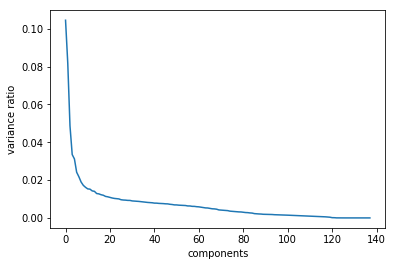

In [39]:
# Investigate the variance accounted for by each principal component.
def top_n_components(variance_explained_pct):
    acc = 0
    for i, variance in enumerate(pca.explained_variance_ratio_):
        acc += variance * 100
        if acc > variance_explained_pct:
            return i+1
    else:
        return i+1
print("Top {} components:".format(10))
for i, variance in enumerate(pca.explained_variance_ratio_[:10]):
    print("Component {} explains {:.03f}% of variance".format(i, variance*100))
print("\nNumber of components that explain {}% variance: {}".format(90, top_n_components(90)))

plt.plot(pca.explained_variance_ratio_)
plt.xlabel('components')
plt.ylabel('variance ratio')
plt.show()

In [40]:
# Re-apply PCA to the data while selecting for number of components to retain.
pca_p = PCA(n_components=70)
pca_p.fit(df_general)
pca_samples = pca_p.transform(df_general)

### Discussion 2.2: Perform Dimensionality Reduction

For a data analysis we would benefit from a smaller set of features, to keep model simpler and interpretable.
Prinicipal component analysis produces a set of new variables that are independent from each other.
Dimensionality reduction is achieved by keeping only those variables - principal components - that explain specified amount of variance in the data set.<br>
The decision is to keep first 70 principal components that capture 90% of variance in the general population data, and exclude dimensions that capture small proportion of total variance (less than 0.5%).



### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [41]:
def map_pca_components_to_features(pca, df):
    df_components = pd.DataFrame(pca.components_,
                                 columns=df.columns,
                                 index = ['PC{}'.format(i+1) for i in range(len(pca.components_))])
    return df_components

def pca_component_feature_weights(df, pc_index):
    key = 'PC{}'.format(pc_index)
    name_weight = [(col, w) for col, w in zip(df.columns, df.loc[key])]
    return sorted(name_weight, key=lambda x: np.abs(x[1]), reverse=True)

In [42]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.
df_pca = map_pca_components_to_features(pca_p, df_general)

print("Principal component #1")
name_weight_coll = [(n, w) for n, w in pca_component_feature_weights(df_pca, 1)]

TOP_K = 10
print("Top {} relevant features".format(TOP_K))
for name, weight in name_weight_coll[:10]:
    print("\t{:<25}: {:.03f}".format(name, weight))
    
print("Top {} irrelevant features".format(TOP_K))
for name, weight in name_weight_coll[-10:][::-1]:
    print("\t{:<25}: {:.03f}".format(name, weight))
    

Principal component #1
Top 10 relevant features
	MOBI_REGIO               : -0.201
	FINANZ_MINIMALIST        : -0.196
	LP_STATUS_GROB_1.0       : 0.194
	HH_EINKOMMEN_SCORE       : 0.185
	PLZ8_ANTG3               : 0.184
	PLZ8_ANTG1               : -0.182
	PLZ8_BAUMAX              : 0.179
	KBA05_ANTG1              : -0.179
	PLZ8_ANTG4               : 0.179
	KBA05_GBZ                : -0.179
Top 10 irrelevant features
	GEBAEUDETYP_4.0          : -0.000
	GFK_URLAUBERTYP_10.0     : -0.001
	GEBAEUDETYP_2.0          : -0.001
	GFK_URLAUBERTYP_9.0      : -0.002
	SOHO_KZ                  : -0.002
	SHOPPER_TYP_1.0          : -0.002
	ANZ_TITEL                : -0.004
	GFK_URLAUBERTYP_8.0      : 0.005
	CAMEO_DEUG_2015_6.0      : -0.005
	LP_FAMILIE_GROB_3.0      : 0.005


In [43]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.
print("Principal component #2")
name_weight_coll = [(n, w) for n, w in pca_component_feature_weights(df_pca, 2)]

print("Top {} relevant features".format(TOP_K))
for name, weight in name_weight_coll[:TOP_K]:
    print("\t{:<25}: {:.03f}".format(name, weight))
    
print("Top {} irrelevant features".format(TOP_K))
for name, weight in name_weight_coll[-TOP_K:][::-1]:
    print("\t{:<25}: {:.03f}".format(name, weight))

Principal component #2
Top 10 relevant features
	youth                    : -0.230
	ALTERSKATEGORIE_GROB     : 0.227
	FINANZ_SPARER            : -0.225
	FINANZ_UNAUFFAELLIGER    : -0.215
	SEMIO_REL                : -0.211
	ZABEOTYP_3.0             : 0.211
	FINANZ_VORSORGER         : 0.211
	FINANZ_ANLEGER           : -0.204
	SEMIO_TRADV              : -0.200
	SEMIO_PFLICHT            : -0.189
Top 10 irrelevant features
	GEBAEUDETYP_4.0          : 0.000
	CAMEO_DEUG_2015_1.0      : 0.000
	GEBAEUDETYP_2.0          : 0.000
	LP_STATUS_GROB_3.0       : -0.001
	SOHO_KZ                  : -0.002
	SHOPPER_TYP_2.0          : 0.002
	wealth_3.0               : -0.004
	KBA05_ANTG2              : -0.004
	movement                 : -0.006
	GREEN_AVANTGARDE         : -0.006


In [44]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.
print("Principal component #3")
print("Top {} relevant features".format(TOP_K))
name_weight_coll = [(n, w) for n, w in pca_component_feature_weights(df_pca, 3)]
for name, weight in name_weight_coll[:TOP_K]:
    print("\t{:<25}: {:.03f}".format(name, weight))
print("Top {} irrelevant features".format(TOP_K))
for name, weight in name_weight_coll[-TOP_K:][::-1]:
    print("\t{:<25}: {:.03f}".format(name, weight))

Principal component #3
Top 10 relevant features
	ANREDE_KZ                : -0.351
	SEMIO_VERT               : 0.330
	SEMIO_KAEM               : -0.318
	SEMIO_DOM                : -0.285
	SEMIO_KRIT               : -0.278
	SEMIO_FAM                : 0.262
	SEMIO_SOZ                : 0.257
	SEMIO_KULT               : 0.256
	SEMIO_ERL                : -0.212
	FINANZ_ANLEGER           : -0.159
Top 10 irrelevant features
	SOHO_KZ                  : -0.000
	GEBAEUDETYP_4.0          : 0.000
	LP_STATUS_GROB_4.0       : 0.000
	GEBAEUDETYP_2.0          : 0.000
	wealth_3.0               : -0.000
	CAMEO_DEUG_2015_5.0      : -0.001
	CAMEO_DEUG_2015_7.0      : 0.001
	wealth_4.0               : -0.001
	ANZ_PERSONEN             : 0.001
	LP_LEBENSPHASE_GROB      : 0.002


### Discussion 2.3: Interpret Principal Components


Each prinicpal component is defined by coefficients of linear combination of features. To find a projection of a sample's point to a principal component, we compute a dot product of the sample's fetaure vector with the principal component's vector - linear combination of the sample's features. We may think of a principal component as a feature that "uncovers" a hidden topic in data.

#### Principal Component #1
Principal component #1 captures characteristics of a household and its social status.

Relevant features:
	- Mobility: MOBI_REGIO
	- Social status: LP_STATUS_GROB_1.0
	- Estimated household net income: HH_EINKOMMEN_SCORE
	- Characteristic of a region by houses: PLZ8_XXX
	- Characteristic of a microcell by houses: KBZ05_XXX
    
#### Principal Component #2
Principal component #2 captures such traits as age, and financial behavior.

Relevant features:
    - Age:youth (engineered feature from movement during years of the youth)
    - Age: ALTERSKATEGORIE_GROB (estmated age)
    - Financial behavior:FINANZ_XXX (financial topology)


#### Principal Component #3
Principal component #3 captures personality and gender.

Relevant features:
    - Gender: ANREDE_KZ
    - Personality:	SEMIO_XXX
    
    
#### Interpretation of feature weight sign.
 
Weight of a feature is a measure of the strength of the linear relationship between two variables: a feature and PCA principal component.
Feature's weight can range from -1 to 1. A weight less than 0 indicates a negative linear relationship between variables, a weight close to 0 indicates small or no linear relationship between variables, and a weight that is greater than 0 indicates a positive linear relationship. 

Signs of the weghts are meaningless, because they will change if an eigenvector - PCA component - points to an opposite direction. But relative signs are not meaningless:  a set of features with identical weights' sign will be invariant per PCA component. Meaning of a sign is that if the feature weight is positive, then a higher score on that feature is associated with a higher score on the component, if the feature weight is negative, then a higher score implies a lower score on the component.

Features with opposite weights' signs are the features with negative correlation. A projection on a principal component is a result of linear combination of features' values, and features with negative correlation should have weights of opposite sign to maximize variance of projections on the principal component.




## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [45]:
def make_clusters(df, n_clusters):
    """
    """
    kmeans = KMeans(n_clusters=n_clusters)
    kmeans = kmeans.fit(df)
    
    prediction = np.array(kmeans.predict(df))    
    centers = np.array(kmeans.cluster_centers_)
    
    # Here we compute SSE score (which is equivalent to KMeans inertia_ value)
    X = df.copy()
    for k in range(n_clusters):
        X[prediction == k] -= centers[k]
    score = np.sum(np.sum(X**2, axis=1)) 
    return kmeans, score

# Over a number of different cluster counts...
# run k-means clustering on the data and...   
# compute the average within-cluster distances.

cluster_count_score = []
for k in range(3, 31, 3):
    _, score = make_clusters(pca_samples, k)
    print("Cluster #: {} score: {:.03f}".format(k, score))
    cluster_count_score.append((k, score)) 

Cluster #: 3 score: 88656602.635
Cluster #: 6 score: 81723170.464
Cluster #: 9 score: 77964400.425
Cluster #: 12 score: 75432050.369
Cluster #: 15 score: 73830728.458
Cluster #: 18 score: 72489364.678
Cluster #: 21 score: 71231025.148
Cluster #: 24 score: 70158515.506
Cluster #: 27 score: 69218354.579
Cluster #: 30 score: 68407386.499


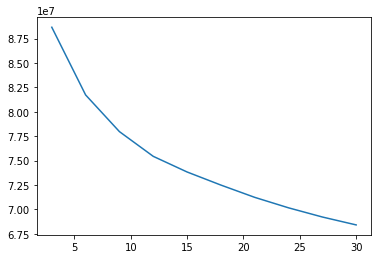

In [46]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.

y = [score for _, score in cluster_count_score]
x = [count for count, _ in cluster_count_score]
plt.plot(x, y)
plt.show()


In [47]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.
NUM_CLUSTERS = 16
kmeans, _ = make_clusters(pca_samples, NUM_CLUSTERS)
prediction_general = kmeans.predict(pca_samples)

### Discussion 3.1: Apply Clustering to General Population

We will apply elbow method to select "optimal" number of clusters:
    - Run KMeans clustering on the general population data set for a range of values of number of clusters.
    - For each value of number of clusters calculate sum of squared distances - SSE - of samples to their closest cluster center.
    - Plot a line graph of the SSE for each number of clusters.
    
The objective is to minimize SSE, and SSE tends to descrease as we increase number of clusters. SSE will reach 0 when number of clusters is equal to number of samples.
We will choose a small number of clusters - using a plot of SSE vs. num clusters - such that increasing number of clusters result in a small reduction of SSE value.

There is no distinct "elbow" point on the SSE plot. Closest point that resembles "elbow" is around 16 clusters.



### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [48]:
# Load in the customer demographics data.
customers = pd.read_csv('Udacity_CUSTOMERS_Subset.csv', delimiter=';')
customers.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,2,4,1,5.0,5,1,5,1,2,2,...,3.0,3.0,1.0,0.0,1.0,5.0,5.0,1.0,2.0,1.0
1,-1,4,1,NaN,5,1,5,1,3,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,-1,4,2,2.0,5,1,5,1,4,4,...,2.0,3.0,3.0,1.0,3.0,3.0,2.0,3.0,5.0,3.0
3,1,4,1,2.0,5,1,5,2,1,2,...,3.0,2.0,1.0,0.0,1.0,3.0,4.0,1.0,3.0,1.0
4,-1,3,1,6.0,3,1,4,4,5,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,3.0,5.0,1.0


In [49]:
customers.shape

(191652, 85)

In [50]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.
df_customers = clean_data(customers)
print("\nData frame shape: {}".format(df_customers.shape))


Data frame shape: (144954, 79)


In [51]:
df_customers, _, _= impute_and_scale_data(df_customers, imputer_general, scaler_general)
print("\nThere {} missing values in encoded data frame".format("are no" if not df_customers.isnull().any().any() else "are"))


There are no missing values in encoded data frame


### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

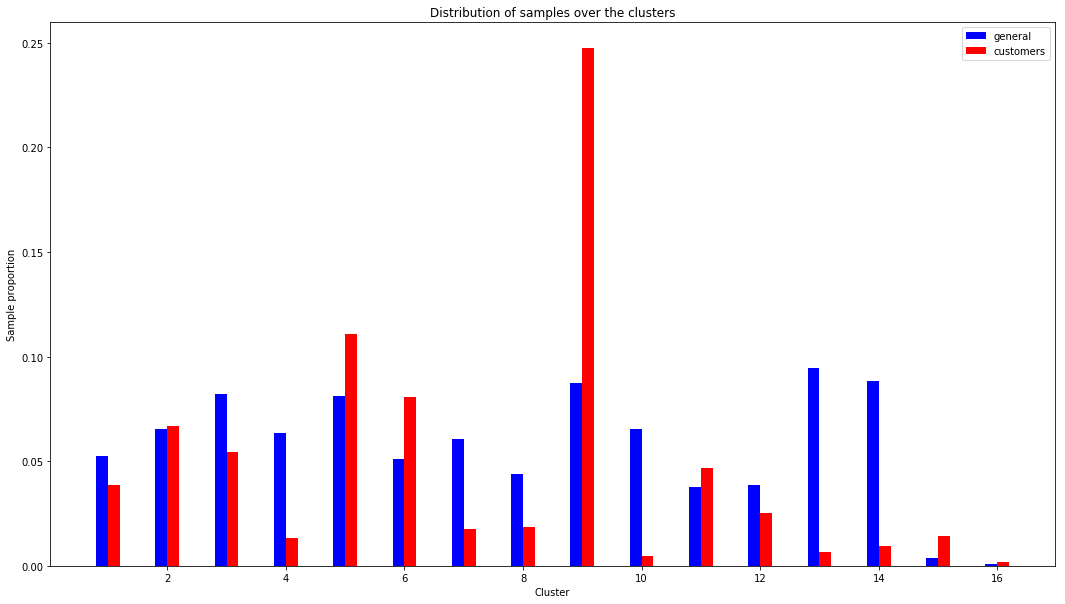

In [52]:
pca_customers = pca_p.transform(df_customers)
prediction_customers = kmeans.predict(pca_customers)

N, _ = azdias.shape
M, _ = customers.shape
cluster_distribution = {
    'general': [(k, np.sum(prediction_general == k)/N) for k in range(NUM_CLUSTERS)],
    'customers': [(k, np.sum(prediction_customers == k)/M) for k in range(NUM_CLUSTERS)],
}

x = np.array([i+1 for i in range(NUM_CLUSTERS)])
fig = plt.figure()
fig.set_size_inches(18, 10)
ax = fig.add_subplot(1,1,1)
bg = ax.bar(x-0.1, [f for _, f in cluster_distribution['general']], width=0.2,color='b',align='center')
bc = ax.bar(x+0.1, [f for _, f in cluster_distribution['customers']], width=0.2,color='r',align='center')
plt.legend((bg[0], bc[0]), ('general', 'customers'))
plt.title("Distribution of samples over the clusters")
plt.ylabel("Sample proportion")
plt.xlabel("Cluster")
plt.show()

In [53]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.
proportions = [(k, f1, f2, f2/f1) 
               for (k, f1), (_, f2 )
               in zip(cluster_distribution['general'], cluster_distribution['customers'])]

proportions = sorted(proportions, key=lambda x: x[3], reverse=True)
print("Proportion of population per cluster.")
print(" - Data rows are ordered by customer-to-general proportions ratio in descending order.")
print(" - Data rows with ratio >> 1.0 represent clusters with target audience for the company.")
print(" - Data rows with ratio << 1.0 represent clusters with samples outside of the target demographics.")
print("==================================================================================================")
for k, f1, f2, ratio in proportions:
    print("Cluster={:<2}...General%: {:.02f}...Customers%: {:<5.02f}...Ratio %: {:<5.02f}".format(k+1, 
                                                                                                       100*f1, 
                                                                                                       100*f2, 
                                                                                                       ratio))

Proportion of population per cluster.
 - Data rows are ordered by customer-to-general proportions ratio in descending order.
 - Data rows with ratio >> 1.0 represent clusters with target audience for the company.
 - Data rows with ratio << 1.0 represent clusters with samples outside of the target demographics.
Cluster=15...General%: 0.35...Customers%: 1.42 ...Ratio %: 4.02 
Cluster=9 ...General%: 8.74...Customers%: 24.75...Ratio %: 2.83 
Cluster=16...General%: 0.07...Customers%: 0.16 ...Ratio %: 2.19 
Cluster=6 ...General%: 5.12...Customers%: 8.08 ...Ratio %: 1.58 
Cluster=5 ...General%: 8.14...Customers%: 11.06...Ratio %: 1.36 
Cluster=11...General%: 3.77...Customers%: 4.69 ...Ratio %: 1.24 
Cluster=2 ...General%: 6.55...Customers%: 6.70 ...Ratio %: 1.02 
Cluster=1 ...General%: 5.24...Customers%: 3.85 ...Ratio %: 0.74 
Cluster=3 ...General%: 8.21...Customers%: 5.42 ...Ratio %: 0.66 
Cluster=12...General%: 3.85...Customers%: 2.51 ...Ratio %: 0.65 
Cluster=8 ...General%: 4.40...Customer

In [54]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?
true_centers = scaler_general.inverse_transform(pca_p.inverse_transform(kmeans.cluster_centers_))
true_centers = pd.DataFrame(np.round(true_centers), columns=df_general.columns)
true_centers.index = ['C_{}'.format(i+1) for i in range(len(true_centers))]

columns = [
    'MOBI_REGIO',
    'LP_STATUS_GROB_1.0',
    'LP_STATUS_GROB_5.0',
    'FINANZ_MINIMALIST',
    'youth',
    'ALTERSKATEGORIE_GROB',
    'FINANZ_SPARER',
    'ANREDE_KZ',
    'SEMIO_VERT',
    'FINANZ_ANLEGER',
    'REGIOTYP',
    'ALTER_HH'
]
display(true_centers.loc[['C_9']][columns])

,MOBI_REGIO,LP_STATUS_GROB_1.0,LP_STATUS_GROB_5.0,FINANZ_MINIMALIST,youth,ALTERSKATEGORIE_GROB,FINANZ_SPARER,ANREDE_KZ,SEMIO_VERT,FINANZ_ANLEGER,REGIOTYP,ALTER_HH
C_9,4.0,0.0,1.0,5.0,67.0,3.0,2.0,1.0,5.0,2.0,3.0,15.0


In [55]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?
display(true_centers.loc[['C_10','C_13']][columns])


,MOBI_REGIO,LP_STATUS_GROB_1.0,LP_STATUS_GROB_5.0,FINANZ_MINIMALIST,youth,ALTERSKATEGORIE_GROB,FINANZ_SPARER,ANREDE_KZ,SEMIO_VERT,FINANZ_ANLEGER,REGIOTYP,ALTER_HH
C_10,2.0,1.0,0.0,2.0,88.0,2.0,5.0,1.0,6.0,4.0,5.0,18.0
C_13,2.0,1.0,-0.0,1.0,86.0,2.0,4.0,2.0,2.0,4.0,5.0,17.0


In [56]:
display(true_centers.loc[['C_9','C_10', 'C_13']][columns].T)

,C_9,C_10,C_13
MOBI_REGIO,4.0,2.0,2.0
LP_STATUS_GROB_1.0,0.0,1.0,1.0
LP_STATUS_GROB_5.0,1.0,0.0,-0.0
FINANZ_MINIMALIST,5.0,2.0,1.0
youth,67.0,88.0,86.0
ALTERSKATEGORIE_GROB,3.0,2.0,2.0
FINANZ_SPARER,2.0,5.0,4.0
ANREDE_KZ,1.0,1.0,2.0
SEMIO_VERT,5.0,6.0,2.0
FINANZ_ANLEGER,2.0,4.0,4.0


### Discussion 3.3: Compare Customer Data to Demographics Data


#### Over-represented cluster in the customer dataset compared to the general population.
Clusters C_9  is where customer dataset is over-represented.
- Cluster 9 contains 8.74% of general population vs. 24.75% of customers.

#### Under-represented cluster(s) in the customer dataset compared to the general population.
Clusters C_10 and C_13 are clusters where customer dataset is under-represented:
- Cluster 10 contains 6.54% of general population vs. 0.46% of customers.
- Cluster 13 contains 9.44% of general population vs. 0.65% of customers.

In order to describe segments of the population represented by clusters we will project clusters' centroids into original - general population - data space. To project clusters' centroids back to general population data space we will
    - apply PCA inverse transform to centroids' coordinates to change basis from principal components to the basis of general population dataset. 
    - apply Standard Scaler inverse transform to recover original scale of the features values.

Having clusters' centroids projected into the general population data space, we will attempt to describe over- and under-represented segments by analyzing values of features that belong to top 5 features of the first three principal components:
    - 'MOBI_REGIO',
    - 'LP_STATUS_GROB_1.0',
    - 'LP_STATUS_GROB_5.0',
    - 'FINANZ_MINIMALIST',
    - 'youth',
    - 'ALTERSKATEGORIE_GROB',
    - 'FINANZ_SPARER',
    - 'ANREDE_KZ',
    - 'SEMIO_VERT',
    - 'FINANZ_ANLEGER',
    - 'REGIOTYP',
    - 'ALTER_HH'

#### Description of cluster 9: cluster with over-represented customers.
Typical customer is
    - Middle aged, 46-60 years old male, who has settled down.
    - Formative years: 1960-ies
    - Top earner, living in upper middle class neighborhood.
    - Financially secure: money saver, potential investor.
    - Does have considerable disposable income.

#### Description of clusters 10, 13: clusters with under-represented customers.
Typical customer is
    - 30-45 years of age, who has potential to move looking for other opportunities.
    - Formative years: late 1990-ies
    - Low income, living in lower middle class neighborhood.
    - Financially insecure: 
        - does not save enough money, 
        - can't be considered as a potential investor.
    - Does not have considerable disposable income.

Population in clusters 10 and 13 differ by 
    - Age: cluster 10 contains population that is approximately 5-10 years yonger than population in cluster 13.
    - Gender: cluster 10 contains samples representing males and cluster 13 contains samples representing females.
    
Summary:

Company's target audience is an older - middle-aged - and financially secure male population.


> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.